In [1]:
#MAE271D Project
# MPC

from algames import ALGAMES
from mpc import MPC

import numpy as np
import matplotlib.pyplot as plt


In [2]:
# M players
M = 3

# N horizon length
N = 10

# n state size
n = 4  # (x, y, v_x, v_y)

# m control input size
m = 2  # (a_x, a_y)

# timestep
dt = 0.1 

# collision avoidance radius
r = 0.25

# running cost matrix
Q = np.eye(n)

# terminal cost matrix
Qf = np.eye(n) * 100

# control cost matrix
R = np.eye(m)

# penalty gain
rho = 0

# penalty schedule
gamma = 1.1

# convergence tolerance
eps = 10

# max iterations
max_iter = 10

# multiplier to enforce dynamics
dynamics_mult = 1000

In [3]:
# initial state
x1_0 = np.array([0, 0, 2, 0.5])
x2_0 = np.array([0, -0.5, 3, 0])
x3_0 = np.array([0.5, 0.25, 0.5, -2])
list_x0 = [x1_0, x2_0, x3_0]

# final state
x1_f = np.array([1.5, 0, 2, 0])
x2_f = np.array([2, 0, 2, 0])
x3_f = np.array([2.5, 0, 2, 0])
list_xf = [x1_f, x2_f, x3_f]

# constraints
constraint_wall_y = 1
constraint_u_x_max = 10
constraint_u_y_max = constraint_u_x_max

In [4]:
X_mpc, U_mpc = MPC(
        M,  # number players
        N,  # horizon
        n,  # state size
        m,  # control input size
        dt,  # timestep
        r,  # collision avoidance radius
        list_x0,  # list of initial states
        list_xf,  # list of target states
        Q,  # running cost matrix
        Qf,  # terminal cost matrix
        R,  # control cost matrix
        rho,  # constraint penalty value
        gamma,  # constraint penalty schedule
        eps,  # convergence tolerance
        constraint_wall_y,  # y value of horizontal wall
        constraint_u_x_max,  # control input x bound
        constraint_u_y_max,  # control input y bound
        max_iter,
        dynamics_mult,
    )

606261.4422944741
610307.5245617601
610307.5245617601
489230.22728610167
489230.22728610167
538184.9278242964
538184.9278242964
546087.1818459276
546087.1818459276
352765.1504467288
334739.8706336622
335921.2376938376
335921.2376938376
461109.3961933367
456135.9419795106
496668.0453798141
496668.0453798141
463539.4086442096
461745.0944271309
461745.0944271309
418250.8853774699
461661.46586941055
461661.46586941055
415682.53465193335
415682.53465193335
287436.61307641666
276272.3850907705
276272.3850907705


Text(0.5, 1.0, 'Position')

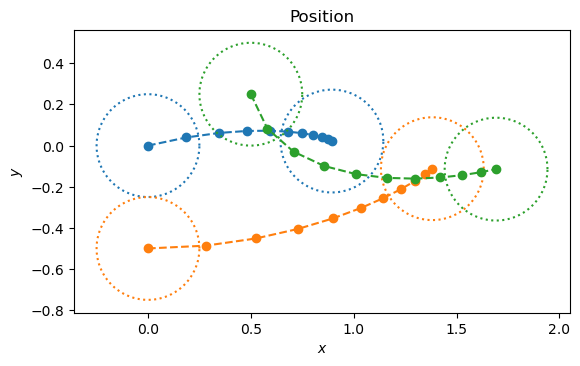

In [5]:
x_players = np.split(X_mpc, M)

# safety radius
th = np.linspace(0, 2 * np.pi, 180)
c_cos = np.cos(th) * r
c_sin = np.sin(th) * r

# plot
plt.figure()
for i, x in enumerate(x_players):
    x = np.reshape(x, (n, N+1), order="F")
    plt.plot(x[0, :], x[1, :], "o--")

    # plot cola radius
    plt.plot(x[0, 0] + c_cos, x[1, 0] + c_sin, ":", c=f"C{i}")
    plt.plot(x[0, -1] + c_cos, x[1, -1] + c_sin, ":", c=f"C{i}")
plt.gca().set_aspect("equal")
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Position")

Text(0.5, 0.98, 'Velocity')

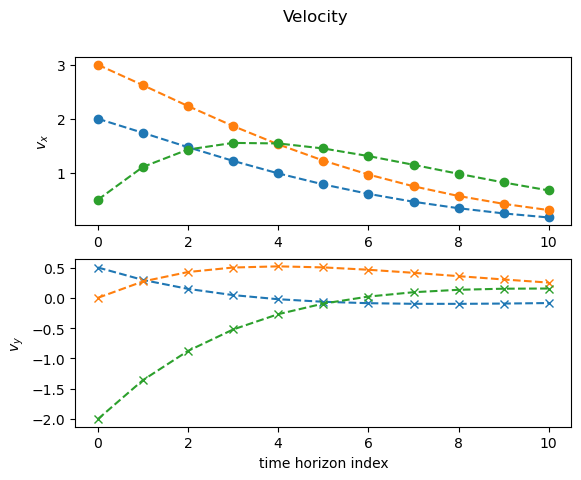

In [6]:
# velocity
plt.figure()
for i, x in enumerate(x_players):
    x = np.reshape(x, (n, N+1), order="F")
    ax = plt.subplot(211)
    ax.plot(x[2, :], "o--", c=f"C{i}")
    plt.ylabel('$v_x$')
    ax = plt.subplot(212)
    ax.plot(x[3, :], "x--", c=f"C{i}")
    plt.ylabel('$v_y$')
plt.xlabel('time horizon index')
plt.suptitle("Velocity")

Text(0.5, 0.98, 'Control input')

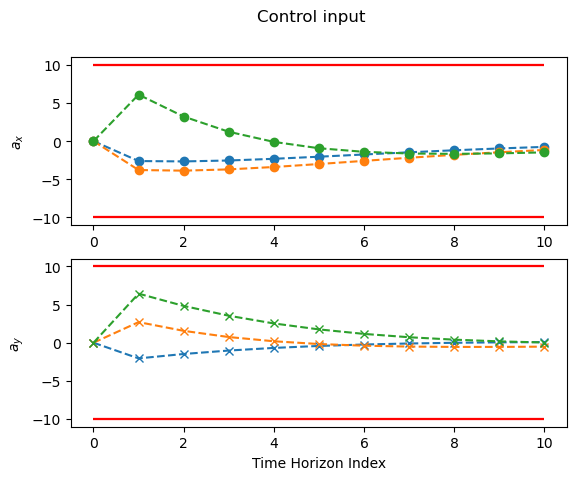

In [7]:
u_players = np.split(U_mpc, M)

# plot
plt.figure()
for i, u in enumerate(u_players):
    u = np.reshape(u, (m, N+1), order="F")
    ax = plt.subplot(211)
    plt.plot(u[0, :], "o--", c=f"C{i}")
    plt.hlines((constraint_u_x_max, -constraint_u_x_max), 0, N, "r")
    plt.ylabel('$a_x$')
    ax = plt.subplot(212)
    plt.plot(u[1, :], "x--", c=f"C{i}")
    plt.hlines((constraint_u_y_max, -constraint_u_y_max), 0, N, "r")
    plt.ylabel('$a_y$')
plt.xlabel('Time Horizon Index')
plt.suptitle("Control input")